# Text-Based Emotion Recognition using Transformers

## 1. Introduction & Problem Statement

Emotions play a vital role in human communication, influencing how messages are understood, interpreted, and responded to. When people express themselves, their emotions provide critical context beyond the literal meaning of words. For instance, the same sentence can be interpreted very differently depending on whether it is said with happiness, anger, or sadness.

In the digital world, the ability to automatically recognize emotions from text is becoming increasingly valuable. Some key applications include:

- **Customer Service**: Detecting frustration or satisfaction in customer messages can help companies respond more effectively and empathetically.  
- **Virtual Assistants & Chatbots**: Emotionally aware systems create more human-like and supportive interactions.  
- **Mental Health Monitoring**: Detecting signs of distress, sadness, or anxiety can provide early warnings and support interventions.  
- **Personalized Recommendations**: Content platforms can adapt suggestions (music, movies, articles) based on user mood.  

### Chosen Approach

In this project, we aim to build a **Text-Based Emotion Recognition system** using **Transformer-based models** (such as **BERT** and **DistilBERT**).  

**Why Transformers?**  
- They are **state-of-the-art** in Natural Language Processing (NLP).  
- Unlike traditional models (Naïve Bayes, SVM, RNNs), Transformers capture **context and semantics** more effectively.  
- They achieve high accuracy in complex text classification tasks.  

### Project Goal

The system will classify transcribed speech text into **13 predefined emotions**:  
`hate, neutral, anger, love, worry, relief, happiness, fun, empty, enthusiasm, sadness, surprise, boredom`.  

Our ultimate goal is to design a robust and accurate emotion recognition system that bridges the gap between **technology and human empathy**, making digital experiences more intuitive, supportive, and human-like.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns





We import libraries for data handling (pandas, numpy), visualization (matplotlib, seaborn), and ML (scikit-learn).

##Load Dataset
We load the dataset and check first few rows + data types. This helps us understand structure.

In [3]:
df = pd.read_csv("/content/drive/MyDrive/EMOTION_DETECTION_SYSTEM/emotion_dataset.csv")
print(df.head())

   Unnamed: 0                                               text  Emotion
0           0  i seriously hate one subject to death but now ...     hate
1           1                 im so full of life i feel appalled  neutral
2           2  i sit here to write i start to dig out my feel...  neutral
3           3  ive been really angry with r and i feel like a...    anger
4           4  i feel suspicious if there is no one outside l...  neutral


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839555 entries, 0 to 839554
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  839555 non-null  int64 
 1   text        839555 non-null  object
 2   Emotion     839555 non-null  object
dtypes: int64(1), object(2)
memory usage: 19.2+ MB
None


In [5]:
df.columns

Index(['Unnamed: 0', 'text', 'Emotion'], dtype='object')

In [6]:
df.drop("Unnamed: 0", axis=1, inplace=True)

## Step 3: Exploratory Data Analysis (EDA)

Before training a model, it is important to understand the dataset.  
Here I will perform three checks:

1. **Missing Values**  
   To confirm whether any text or emotion labels are missing.  

2. **Class Distribution**  
   Plot how many examples belong to each emotion category. This helps detect imbalance in the dataset (e.g., many `neutral` rows but very few `boredom` rows).  

3. **Example Samples**  
   Display example text rows for each emotion to better understand the data qualitatively.  

This step ensures that the dataset is complete, balanced (or imbalanced), and suitable for model training.


###Missing Values

In [ ]:
#Check missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
text       0
Emotion    0
dtype: int64


###Class Distribution

In [9]:
emotion_counts = df['Emotion'].value_counts()
print(emotion_counts)



Emotion
neutral       674538
love           39553
happiness      27175
sadness        17481
relief         16729
hate           15267
anger          12336
fun            10075
enthusiasm      9304
surprise        6954
empty           5542
worry           4475
boredom          126
Name: count, dtype: int64


/tmp/ipython-input-4174518012.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis")


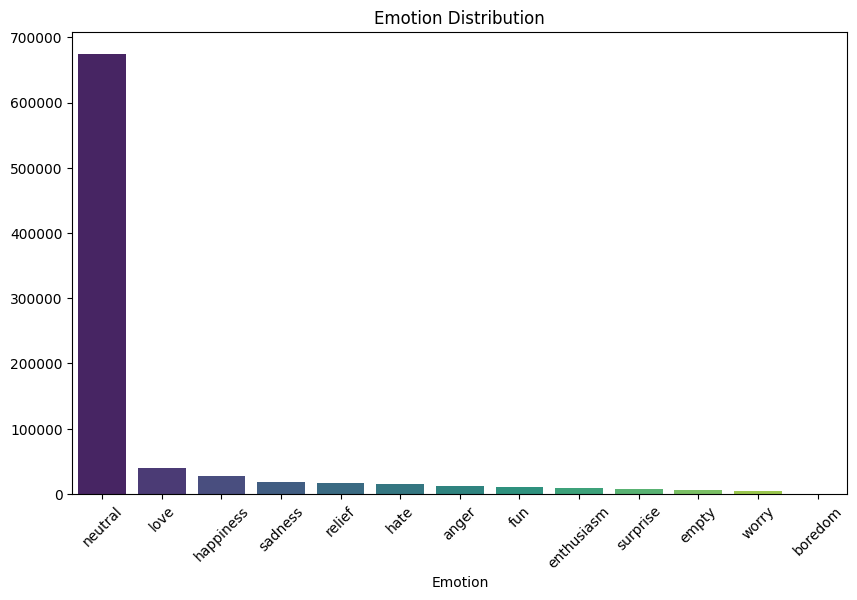

In [10]:
plt.figure(figsize=(10,6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Emotion Distribution")
plt.show()

###Example Samples

In [13]:
for emo in df["Emotion"].unique():
    sample_text = df[df["Emotion"] == emo]["text"].iloc[0]
    print(f"{emo:>12} : {sample_text}")

        hate : i seriously hate one subject to death but now i feel reluctant to drop it
     neutral : im so full of life i feel appalled
       anger : ive been really angry with r and i feel like an idiot for trusting him in the first place
        love : i feel jealous becasue i wanted that kind of love the true connection between two souls and i wanted that
       worry : i finally fell asleep feeling angry useless and still full of anxiety
      relief : i am sitting here typing this and wondering where i belong feeling distracted feeling comfortable feeling misunderstood and hurt
   happiness : i expect and i feel content with that
         fun : i would feel joyful
       empty : i feel and some is just a hateful of hollow yes i hear many smiths these days
  enthusiasm : im so excited but feeling kind of shy about it smile
     sadness : i felt like the boys were disadvantaged missing out on all the exciting entertainments at home for children but now i feel like they have had 


- **Missing Values**: No major missing data found.  
- **Class Distribution**: The dataset is highly imbalanced.  
  - **Neutral** has the largest share (674k samples).  
  - **Boredom** has very few samples (126).  
- **Sample Texts**: Example rows confirm that texts reflect emotional expressions, but class sizes vary a lot.  

**Interpretation**:  
The strong imbalance means the model may overfit to the **neutral** class.  
This will need to be addressed later (e.g., class weights or resampling).  


## Step 4: Data Preprocessing (For Transformers)

Traditional NLP pipelines (Naïve Bayes, SVM, RNN) usually require heavy text preprocessing such as stopword removal, punctuation removal, and stemming. However, Transformer models like **BERT** and **DistilBERT** already come with powerful tokenizers and embeddings that understand context, punctuation, and subwords.  

### Preprocessing choices:
1. **Remove empty rows** – ensure no blank text goes into the model.  
2. **Lowercasing** – if we use `bert-base-uncased`, the tokenizer already lowercases, so this step is optional.  
3. **Keep punctuation, emojis, etc.** – Transformers learn from them and can extract meaning.  
4. **No stopword removal** – words like *“not”* or *“very”* change sentiment/emotion, so removing them would harm performance.  

**-->** In short: Transformers need **minimal preprocessing** because the tokenizer handles most of the work.


In [12]:
# Drop rows with empty or null text
df = df.dropna(subset=["text"])
df = df[df["text"].str.strip() != ""]

# lowercase text if you want consistency
df["text"] = df["text"].str.lower()

print("After preprocessing:")
print(df.info())
print("\nSample rows:")
display(df.head())


After preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839555 entries, 0 to 839554
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     839555 non-null  object
 1   Emotion  839555 non-null  object
dtypes: object(2)
memory usage: 12.8+ MB
None

Sample rows:


,text,Emotion
0,i seriously hate one subject to death but now ...,hate
1,im so full of life i feel appalled,neutral
2,i sit here to write i start to dig out my feel...,neutral
3,ive been really angry with r and i feel like a...,anger
4,i feel suspicious if there is no one outside l...,neutral


## Step 5: Train-Test Split

To evaluate the performance of our model, we divide the dataset into two parts:

- **Training set (70%)**: Used by the model to learn the patterns between text and emotions.  
- **Testing set (30%)**: Used only after training, to check how well the model generalizes to unseen data.  

### Why is this important?
If we train and test on the same data, the model may simply memorize patterns (overfitting) and perform poorly on new inputs.  
By splitting the dataset, we ensure the model is evaluated fairly on unseen examples, giving a realistic measure of performance.


In [17]:
from sklearn.model_selection import train_test_split

# Features and labels
X = df["text"].values
y = df["Emotion"].values

# Split into train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))


Training set size: 587688
Testing set size: 251867


##Model building and trainig i will use different vectroizers and models

In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [20]:
# Training model by CountVectorizer and LinearSVC
model_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000, stop_words='english')),
    ('clf', LinearSVC(class_weight='balanced'))
])

In [21]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', LinearSVC(class_weight='balanced'))])

In [22]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
#Evaluation for the LinearSVC
y_pred = model_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9801164900522895
              precision    recall  f1-score   support

       anger       0.98      0.93      0.95      3701
     boredom       0.45      0.53      0.49        38
       empty       0.48      0.52      0.50      1663
  enthusiasm       0.99      0.97      0.98      2791
         fun       0.96      0.88      0.92      3022
   happiness       0.99      0.97      0.98      8153
        hate       0.99      0.82      0.90      4580
        love       0.99      0.98      0.99     11866
     neutral       0.98      0.99      0.99    202362
      relief       0.94      0.86      0.90      5019
     sadness       0.99      0.96      0.98      5244
    surprise       0.99      0.98      0.99      2086
       worry       0.99      0.98      0.99      1342

    accuracy                           0.98    251867
   macro avg       0.90      0.87      0.89    251867
weighted avg       0.98      0.98      0.98    251867



In [24]:
# Training model by CountVectorizer and Logisticreg
logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=10000, stop_words='english')),
    ('clf', LogisticRegression(max_iter=200, class_weight='balanced'))
])

In [25]:
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=200))])

In [26]:
y_pred = logreg_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9364227945701501
              precision    recall  f1-score   support

       anger       0.95      0.96      0.96      3701
     boredom       0.55      0.95      0.69        38
       empty       0.13      0.84      0.23      1663
  enthusiasm       0.99      0.99      0.99      2791
         fun       0.87      0.95      0.91      3022
   happiness       0.98      0.98      0.98      8153
        hate       0.60      0.88      0.71      4580
        love       1.00      0.98      0.99     11866
     neutral       0.99      0.93      0.96    202362
      relief       0.72      0.91      0.81      5019
     sadness       0.99      0.96      0.98      5244
    surprise       0.99      0.99      0.99      2086
       worry       0.99      0.99      0.99      1342

    accuracy                           0.94    251867
   macro avg       0.83      0.95      0.86    251867
weighted avg       0.97      0.94      0.95    251867



here i train 2 models linearsvc and logistic regression so svc give me 98% accuracy but mat be still overfitting and logistice regression give me the best results 93% but gernalizing so i am keeping logistic regresson for now


In [28]:
import joblib

# Save full pipeline (TF-IDF + Logistic Regression)
joblib.dump(logreg_pipeline, "emotion_detector.pkl")

['emotion_detector.pkl']